In [61]:
from os.path import join
from os import listdir
import os
import mne
from mne.io import read_raw_edf
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE as tSNE
from scipy.spatial.distance import cdist
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.signal import hilbert
from scipy.signal import argrelextrema

In [45]:
os.listdir("../../../../../../Volumes/LaCie/EEG/data_mishra2020")

['.DS_Store',
 '507',
 '507EEG.csv',
 '507_Depression_REST.mat',
 '508_Depression_REST.mat',
 '509_Depression_REST.mat',
 '510_Depression_REST.mat',
 '511_Depression_REST.mat',
 '512_Depression_REST.mat',
 '513_Depression_REST.mat',
 '514_Depression_REST.mat',
 'Data_4_Import_REST.xlsx']

In [46]:
# reading mat file
import scipy.io
mat = scipy.io.loadmat('../../../../../../Volumes/LaCie/EEG/data_mishra2020/507_Depression_REST.mat')

In [47]:
import pandas as pd


mat = {k:v for k, v in mat.items() if k[0] != '_'}
data = pd.DataFrame({k: pd.Series(v[0]) for k, v in iter(mat.items())})

In [59]:
# extracting data from mat
X  = data['EEG'][0][15][:64].T
t = np.array(data['EEG'][0][14]).squeeze()

In [62]:
bounds = [2, 30]
#    'theta' : [4, 8],
#    'alpha': [8, 13],
#    'beta': [13, 30],
#    'gamma': [30, 45]

def get_filter(sfreq=125.):

    f_low_lb = bounds[0] - 1
    f_low_ub = bounds[0]
    f_high_lb = bounds[1]
    f_high_ub = bounds[1] + 1

    nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate

    freq = [0., f_low_lb, f_low_ub, f_high_lb, f_high_ub, nyq]
    gain = [0, 0, 1, 1, 0, 0]
    n = int(round(1 * sfreq)) + 1

    filt = signal.firwin2(n, freq, gain, nyq=nyq)

    return filt
def apply_filter(filt, sig):
    sig = np.convolve(filt, sig, 'valid')
    #sig = hilbert(sig)
    #\
    #sig = np.abs(sig)#np.abs(sig)np.real(sig)
    return sig

In [63]:
def AR(df):
    for i in df.columns[1:]:
        df[i] = df[i] - df[i].mean()
    return df

In [80]:
#Функциии для применения фильтров и подсчета gfp
def get_filtered_data(df):# to improve
    filt = get_filter()
    filtered = np.linspace(0,(df.shape[0] - 125)*8, (df.shape[0] - 125))
    for i in df.columns:
        a = apply_filter(filt, df[i])
        filtered = np.vstack((filtered,a))
    return filtered
def prepare(filtered):
    X = filtered[1:].T
    return X
def compute_gfp_maximas(X, window , norm):
    # channels goes in 1 axis
    if 'L2' == norm:
        gfp = np.var(X, axis=1)
    elif 'L1' == norm:
        gfp = np.sum(np.abs(X - np.outer(np.mean(X, axis = 1 ),np.ones(X.shape[1]))), axis = 1 )
    maximas = argrelextrema(gfp, np.greater, order=window)
    maximal_states = X[maximas[0],:]
    return gfp, maximas, maximal_states

In [65]:
# функция для получения лейблов по разметке
# Визуализация 
# Последняя функция для отбора заданной доли точек с с большими gfp (нигде не используется)
def get_labels(X,cent_history,dist=cdist):
    distances = dist(X, cent_history)
    labels = distances.argmin(axis=1)
    return labels
def visualise_clusters_2d(X,labels,embedding,n=4):
    X_old = X
    #X = embedding.fit_transform(X)
    print(X.shape)
    X = embedding.fit_transform(X)
    #plt.subplot(2, 2, i + 1)
    plt.figure()
    for i in range(n):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], label='cluster #'+str(i))
    #plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co')#, label='cluster #2')
    #plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo')#, label='cluster #3')
    #plt.plot(X[labels == 3, 0], X[labels == 3, 1],  'ro')#,label='cluster #4')
    
    plt.legend(loc=0)
    #plt.title('Step {:}'.format(i + 1))
    #plt.ylim(-7000,-6500)
    X = X_old
def visualise_clusters_3d(X,labels,embedding,n=4):
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    X = embedding.fit_transform(X)

    ax.scatter(
      xs=X[:,0], 
      ys=X[:,1], 
      zs=X[:,2], 
      c=labels)
    plt.show()
def get_ratio(gfp,ratio,X):
    N = int(ratio*len(gfp))
    ind = sorted(range(len(gfp)), key=lambda i:gfp[i])
    if mode == 'high':
        return X[ind[:N]]
    if mode == 'low':
        return X[ind[-N:]]

In [112]:
def spatial_corr(V,u):
    s = V.shape[0]
    G = np.zeros(s)
    for i in range(s):
        C=np.corrcoef(V[i],u)
        G[i] = C[0,1]
    return G
def GEV(labels, gfp, X, history,n=4):
    C = np.zeros((n, len(gfp)))
    for i in range(n):
        C[i] = spatial_corr(X,history[i])
    return np.dot(C**2,gfp**2)/np.sum(gfp**2)

In [121]:

ten_twenty_montage = mne.channels.make_standard_montage('biosemi64')

# create Info object to store info
info = mne.io.meas_info.create_info(ten_twenty_montage.ch_names, sfreq=256, ch_types="eeg")
# using temporary RawArray to apply mongage to info
mne.io.RawArray(np.zeros((len(ten_twenty_montage.ch_names), 1)), info, copy=None).set_montage(ten_twenty_montage)

# pick channels
channels_to_use_ = info.ch_names#[ch for ch in info.ch_names if ch.lower() in channels_to_use]
info.pick_channels(channels_to_use_);

# get positions
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');



Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [67]:
#Функция для получения кластеров
def get_clusters(X, n=4, dist=cdist, dist_mode='cos', crit = 0.00001, alg_mode = None, swap = False, starting_mode = None):
    x = X.shape[0]
    starting_points = np.random.randint(0,x,n)

    centroids = X[starting_points,:]
    if starting_mode == 'pca':
        pca = PCA(4)
        pca.fit_transform(X)
        centroids = pca.components_
    cent_history = []
    #cent_history.append(centroids)
    shift = np.ones(n)
    iter = 0
    while max(np.abs(shift))>crit and iter < 1000:
        iter +=1
        if dist_mode == 'dist':
            distances = dist(X, centroids)
            labels = distances.argmin(axis=1)
        elif dist_mode == 'ort_dist':
            norms=np.linalg.norm(centroids, axis=1)
            c = np.multiply(centroids,1/norms.reshape(norms.shape[0], 1))
            distances = np.zeros((X.shape[0],n))
            for i in range(X.shape[0]):
                for j in range(n):
                    distances[i,j] = np.linalg.norm(np.dot(X[i], c[j])*c[j] - X[i])
            labels = distances.argmin(axis=1)
        elif dist_mode == 'cos':
            distances = np.zeros((X.shape[0],n))
            for i in range(X.shape[0]):
                for j in range(n):
                    distances[i,j] = np.abs(np.dot(X[i], centroids[j])/(np.linalg.norm(X[i])*np.linalg.norm(centroids[j])))#,np.abs(1-np.dot(X[i], centroids[j])/(np.linalg.norm(X[i])*np.linalg.norm(centroids[j]))))
            labels = distances.argmax(axis=1)
        shift = np.ones(n)
        if alg_mode == 'm_k-means':
            centroids = centroids.copy()
            for i in range(n):
                V = np.dot(X[labels == i, :].T, X[labels == i, :])
                pca = PCA(1)
                pca.fit_transform(V)
                e = centroids[i, :].copy() 
                centroids[i, :]= pca.components_.copy()/np.linalg.norm(pca.components_.copy())
                shift[i] = np.linalg.norm(e-centroids[i, :])

        else:
            centroids = centroids.copy()
            for i in range(n):
                e = centroids[i, :].copy() 
                centroids[i, :]= np.mean(X[labels == i, :], axis=0)
                shift[i] = np.linalg.norm(e-centroids[i, :])
        if swap == True and alg_mode == 'm_k-means':
            alg_mode = None
        elif swap == True and alg_mode == None:
            alg_mode = 'm_k-means'
    #print(max(shift))
    code = max(shift)
    return centroids, labels, code, X[starting_points,:]

In [70]:
for i in range(4):
    mne.viz.plot_topomap(total_centroids[i], pos, names=ch_names, show_names=True)

In [108]:
# GFP Computation

df = pd.DataFrame(X, columns=[*range(X.shape[1])])
df = AR(df)
filtered = get_filtered_data(df)

X = prepare(filtered)
#X_1 = prepare(filtered_1)
gfp, maximas, maximal_states = compute_gfp_maximas(X, 5, 'L1')
#gfp_1, maximas_1, maximal_states_1 = compute_gfp_maximas(X_1, 5)
print(gfp)

[2.54969749e+02 3.31644212e+02 3.09363516e+02 ... 7.03031538e+05
 5.98683670e+05 2.38200205e+05]


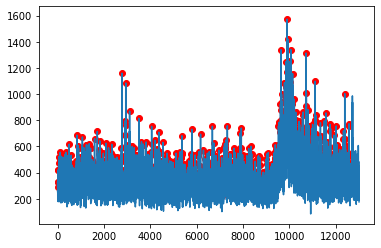

In [109]:
plt.plot(gfp[:13000])
plt.scatter(maximas[0][:1000],gfp[maximas[0][:1000]], c='red')

In [119]:

n = 4
n_iter = 10
history, _, _, init =get_clusters(X[maximas[0],:],crit = 1e-7,dist_mode = 'cos', alg_mode = 'm_k-means')#, starting_mode = 'pca')#, swap = True)
labels = get_labels(X,history)
centre_true = history
labels_true = labels
gev = GEV(labels, gfp, X, history,n)
for i in range(n_iter):
    history, _, _, init =get_clusters(X[maximas[0],:],crit = 1e-7,dist_mode = 'cos', alg_mode = 'm_k-means')#, starting_mode = 'pca')#, swap = True)
    labels = get_labels(X,history)
    gev_to_try = GEV(labels, gfp, X, history,n)
    if np.min(gev) > np.min(gev_to_try):
        continue
    else:
        centre_true = history
        labels_true = labels
        gev = gev_to_try

    #labels_1 = get_labels(X_1,history_1)

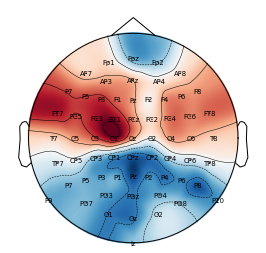

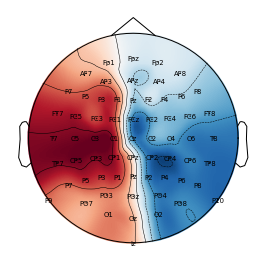

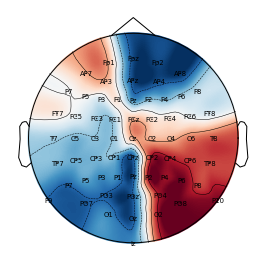

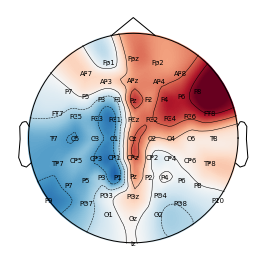

In [122]:
for i in range(4):
    mne.viz.plot_topomap(history[i], pos, names=ch_names, show_names=True)